In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#resnet50V2 - 2class 학습(ciga, vape) - original

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=128, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=128, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=128, class_mode='binary', shuffle=False)

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
# 모델 학습
history = model.fit(train_generator, epochs=30, validation_data=valid_generator)

Epoch 1/30
94/94 [==============================] - 1675s 18s/step - loss: 0.2532 - accuracy: 0.9046 - val_loss: 0.2397 - val_accuracy: 0.9022
Epoch 2/30
94/94 [==============================] - 71s 754ms/step - loss: 0.0883 - accuracy: 0.9696 - val_loss: 0.2181 - val_accuracy: 0.9187
Epoch 3/30
94/94 [==============================] - 70s 745ms/step - loss: 0.0441 - accuracy: 0.9867 - val_loss: 0.2160 - val_accuracy: 0.9239
Epoch 4/30
94/94 [==============================] - 72s 758ms/step - loss: 0.0213 - accuracy: 0.9954 - val_loss: 0.2161 - val_accuracy: 0.9256
Epoch 5/30
94/94 [==============================] - 71s 749ms/step - loss: 0.0074 - accuracy: 0.9998 - val_loss: 0.2275 - val_accuracy: 0.9282
Epoch 6/30
94/94 [==============================] - 72s 759ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.2963 - val_accuracy: 0.9135
Epoch 7/30
94/94 [==============================] - 71s 752ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2592 - val_accuracy: 0.9291

5/5 [==============================] - 106s 26s/step - loss: 0.4107 - accuracy: 0.9055
Test Accuracy: 0.9055258631706238
5/5 [==============================] - 4s 592ms/step


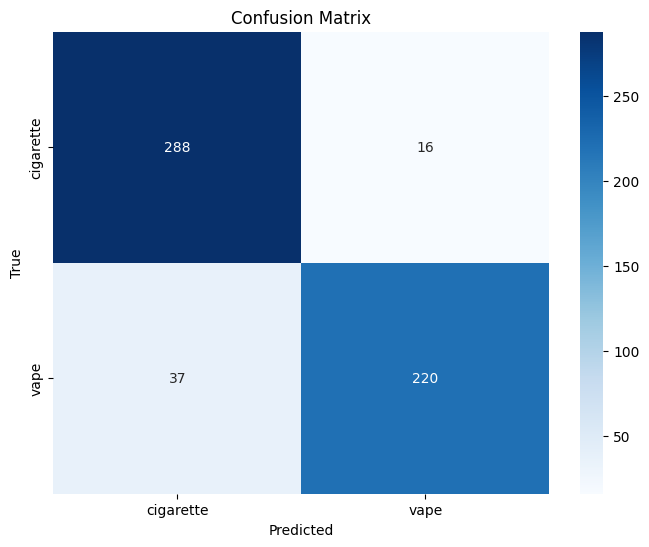

              precision    recall  f1-score   support

   cigarette       0.89      0.95      0.92       304
        vape       0.93      0.86      0.89       257

    accuracy                           0.91       561
   macro avg       0.91      0.90      0.90       561
weighted avg       0.91      0.91      0.91       561

{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}


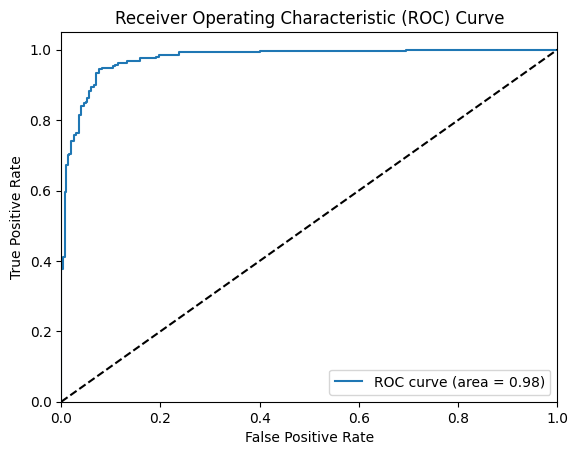

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()  # 임계값 0.5로 이진화

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = test_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, Y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


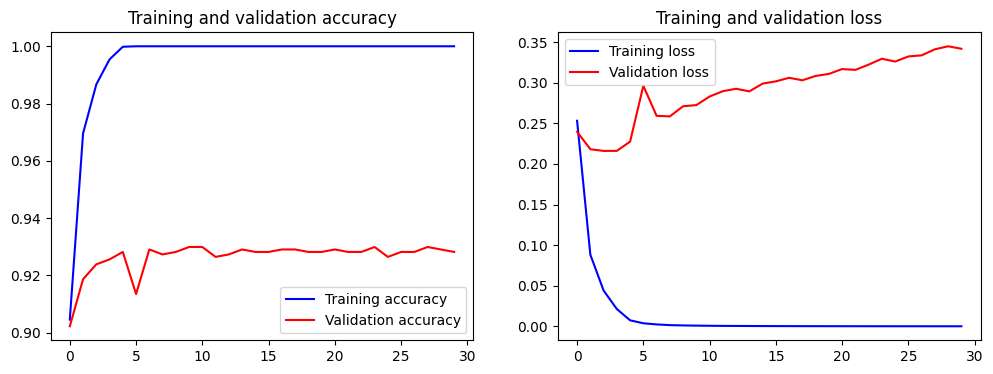

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#resnet50V2 - 2class 학습(ciga, vape) - 하이퍼 파라미터 조정


In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표
    patience=10,         # 개선되지 않더라도 기다리는 에포크 수
    min_delta=0.001,     # 성능 향상으로 간주할 최소 변화량
    restore_best_weights=True,  # 성능이 가장 좋았던 가중치 복원
    mode='min'           # 'val_loss'는 최소화를 목표로 함
)

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

#***경로 변경***
model_name = 'ResNet50V2_2class(vape,cigarette)'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                             monitor='val_loss',
                             save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks = [checkpoint, early_stopping])

Epoch 1/50
376/376 [==============================] - 82s 207ms/step - loss: 0.4317 - accuracy: 0.8020 - val_loss: 0.4035 - val_accuracy: 0.8054
Epoch 2/50
376/376 [==============================] - 81s 215ms/step - loss: 0.2602 - accuracy: 0.8982 - val_loss: 0.3381 - val_accuracy: 0.8365
Epoch 3/50
376/376 [==============================] - 79s 211ms/step - loss: 0.2128 - accuracy: 0.9180 - val_loss: 0.3106 - val_accuracy: 0.8529
Epoch 4/50
376/376 [==============================] - 80s 213ms/step - loss: 0.1851 - accuracy: 0.9318 - val_loss: 0.2935 - val_accuracy: 0.8625
Epoch 5/50
376/376 [==============================] - 81s 214ms/step - loss: 0.1661 - accuracy: 0.9409 - val_loss: 0.2783 - val_accuracy: 0.8772
Epoch 6/50
376/376 [==============================] - 78s 206ms/step - loss: 0.1512 - accuracy: 0.9473 - val_loss: 0.2712 - val_accuracy: 0.8763
Epoch 7/50
376/376 [==============================] - 80s 213ms/step - loss: 0.1394 - accuracy: 0.9520 - val_loss: 0.2626 - val_ac

18/18 [==============================] - 3s 149ms/step - loss: 0.2944 - accuracy: 0.8663
Test Accuracy: 0.866310179233551
18/18 [==============================] - 3s 149ms/step


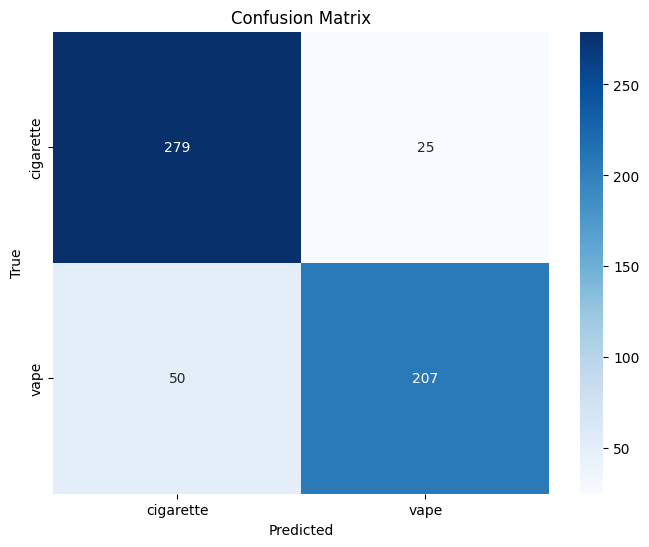

              precision    recall  f1-score   support

   cigarette       0.85      0.92      0.88       304
        vape       0.89      0.81      0.85       257

    accuracy                           0.87       561
   macro avg       0.87      0.86      0.86       561
weighted avg       0.87      0.87      0.87       561

{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}


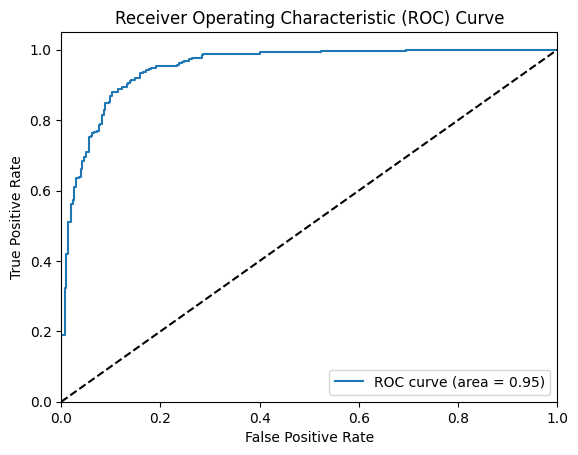

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 데이터 로드
#test_datagen = ImageDataGenerator(rescale=1./255)
#test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# 저장된 모델 불러오기
#model_path = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/model_folder/mymodel.h5'
#model_path = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/ResNet50V2_2class(vape,cigarette)'
#model = tf.keras.models.load_model(model_path)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()  # 임계값 0.5로 이진화

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = test_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, Y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#resnet50V2 - 2class 학습(ciga, vape) - 학습률 낮게
learning_rate = 0.000001

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표
    patience=10,         # 개선되지 않더라도 기다리는 에포크 수
    min_delta=0.001,     # 성능 향상으로 간주할 최소 변화량
    restore_best_weights=True,  # 성능이 가장 좋았던 가중치 복원
    mode='min'           # 'val_loss'는 최소화를 목표로 함
)

learning_rate = 0.000001
optimizer = Adam(learning_rate=learning_rate)

#***경로 변경***
model_name = 'ResNet50V2_2class(vape,cigarette)'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                             monitor='val_loss',
                             save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks = [checkpoint, early_stopping])

Epoch 1/50
376/376 [==============================] - 143s 371ms/step - loss: 0.7114 - accuracy: 0.5813 - val_loss: 0.6248 - val_accuracy: 0.6574
Epoch 2/50
376/376 [==============================] - 80s 213ms/step - loss: 0.5576 - accuracy: 0.7232 - val_loss: 0.5571 - val_accuracy: 0.7258
Epoch 3/50
376/376 [==============================] - 79s 210ms/step - loss: 0.4804 - accuracy: 0.7830 - val_loss: 0.5102 - val_accuracy: 0.7491
Epoch 4/50
376/376 [==============================] - 80s 214ms/step - loss: 0.4294 - accuracy: 0.8191 - val_loss: 0.4774 - val_accuracy: 0.7716
Epoch 5/50
376/376 [==============================] - 77s 204ms/step - loss: 0.3924 - accuracy: 0.8410 - val_loss: 0.4567 - val_accuracy: 0.7751
Epoch 6/50
376/376 [==============================] - 78s 206ms/step - loss: 0.3644 - accuracy: 0.8542 - val_loss: 0.4315 - val_accuracy: 0.7846
Epoch 7/50
376/376 [==============================] - 82s 219ms/step - loss: 0.3420 - accuracy: 0.8671 - val_loss: 0.4146 - val_a

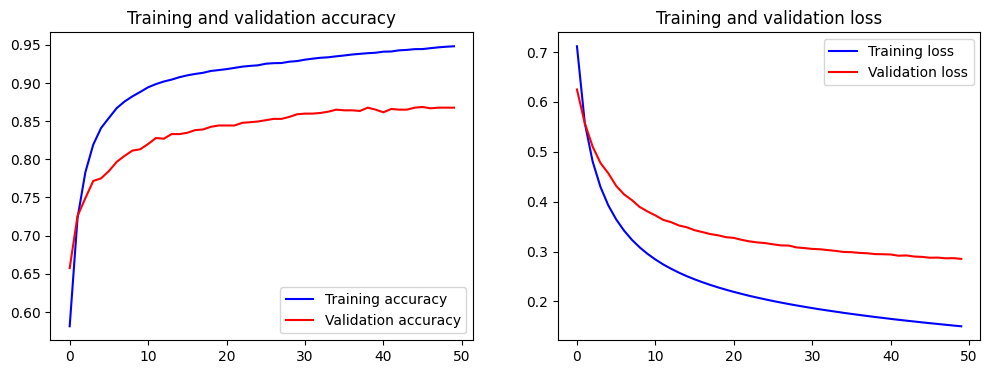

18/18 [==============================] - 3s 145ms/step - loss: 0.2944 - accuracy: 0.8663
Test Accuracy: 0.866310179233551
18/18 [==============================] - 4s 145ms/step


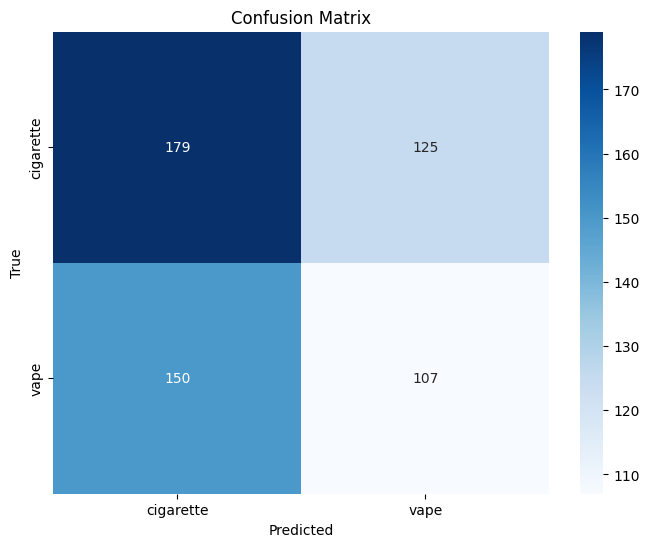

              precision    recall  f1-score   support

   cigarette       0.54      0.59      0.57       304
        vape       0.46      0.42      0.44       257

    accuracy                           0.51       561
   macro avg       0.50      0.50      0.50       561
weighted avg       0.51      0.51      0.51       561



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = np.round(Y_pred).astype(int).flatten()

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)


{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}
37/37 [==============================] - 6s 155ms/step


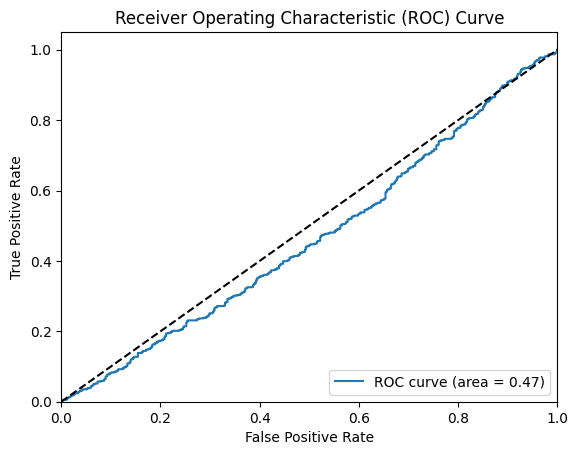

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
y_pred_prob = model.predict(valid_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = valid_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#resnet50V2 - 2class 학습(ciga, vape) - 학습률 그대로, epoch 높게
* 학습 데이터 통합

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표
    patience=10,         # 개선되지 않더라도 기다리는 에포크 수
    min_delta=0.001,     # 성능 향상으로 간주할 최소 변화량
    restore_best_weights=True,  # 성능이 가장 좋았던 가중치 복원
    mode='min'           # 'val_loss'는 최소화를 목표로 함
)

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

#***경로 변경***
model_name = 'ResNet50V2_2class(vape,cigarette)V2'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                             monitor='val_loss',
                             save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_generator, epochs=200, validation_data=valid_generator, callbacks = [checkpoint, early_stopping])

Epoch 1/200
376/376 [==============================] - 2297s 6s/step - loss: 0.7054 - accuracy: 0.6290 - val_loss: 0.5422 - val_accuracy: 0.7465
Epoch 2/200
376/376 [==============================] - 89s 237ms/step - loss: 0.4930 - accuracy: 0.7672 - val_loss: 0.4670 - val_accuracy: 0.7725
Epoch 3/200
376/376 [==============================] - 91s 241ms/step - loss: 0.4195 - accuracy: 0.8143 - val_loss: 0.4251 - val_accuracy: 0.7863
Epoch 4/200
376/376 [==============================] - 89s 236ms/step - loss: 0.3710 - accuracy: 0.8409 - val_loss: 0.3977 - val_accuracy: 0.7993
Epoch 5/200
376/376 [==============================] - 90s 238ms/step - loss: 0.3426 - accuracy: 0.8538 - val_loss: 0.3729 - val_accuracy: 0.8192
Epoch 6/200
376/376 [==============================] - 92s 245ms/step - loss: 0.3273 - accuracy: 0.8616 - val_loss: 0.3598 - val_accuracy: 0.8209
Epoch 7/200
376/376 [==============================] - 90s 238ms/step - loss: 0.3126 - accuracy: 0.8716 - val_loss: 0.3447 - 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = np.round(Y_pred).astype(int).flatten()

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)


NameError: name 'history' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
y_pred_prob = model.predict(valid_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = valid_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

##동결 풀고 미세조정

In [ ]:
# 상위 레이어 고정 해제 후 미세 조정
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_name = 'ResNet50V2_finetuning'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                             monitor='val_loss',
                             save_best_only=True)

history_fine = model.fit(
    train_generator,
    epochs=200,
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/200
376/376 [==============================] - 3645s 10s/step - loss: 0.1744 - accuracy: 0.9334 - val_loss: 0.2232 - val_accuracy: 0.9057
Epoch 2/200
376/376 [==============================] - 140s 371ms/step - loss: 0.0520 - accuracy: 0.9855 - val_loss: 0.2099 - val_accuracy: 0.9118
Epoch 3/200
376/376 [==============================] - 142s 376ms/step - loss: 0.0225 - accuracy: 0.9949 - val_loss: 0.2033 - val_accuracy: 0.9230
Epoch 4/200
376/376 [==============================] - 120s 320ms/step - loss: 0.0098 - accuracy: 0.9988 - val_loss: 0.2144 - val_accuracy: 0.9247
Epoch 5/200
376/376 [==============================] - 120s 319ms/step - loss: 0.0060 - accuracy: 0.9994 - val_loss: 0.2312 - val_accuracy: 0.9230
Epoch 6/200
376/376 [==============================] - 120s 319ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.2375 - val_accuracy: 0.9265
Epoch 7/200
376/376 [==============================] - 120s 319ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.

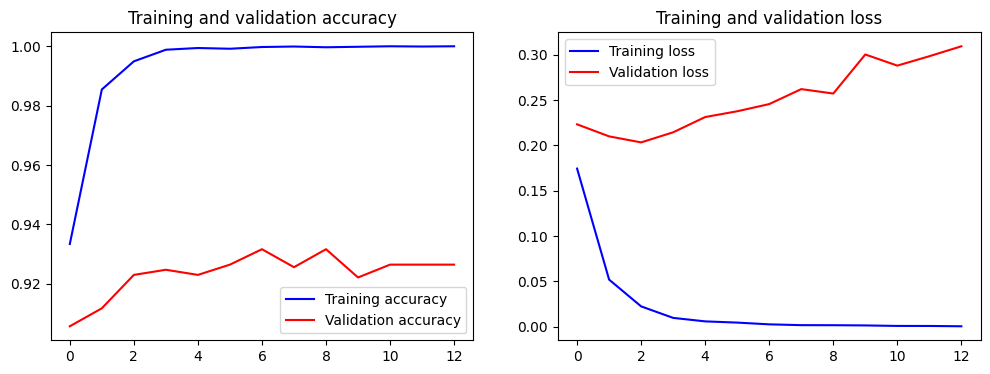

NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time
# 학습 결과 시각화
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = np.round(Y_pred).astype(int).flatten()

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
y_pred_prob = model.predict(valid_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = valid_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#resnet50V2 - 2class 학습(smoking, non-smoking)

* 학습 데이터 통합

In [ ]:
import os
import shutil

# Define source and destination paths
base_path = "/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/"
temp_path = "/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/temp/"
dest_path = "/content/drive/MyDrive/Colab Notebooks/3차프로젝트/2class(smoking-nonsmoking)/"

# Define directories to be merged
directories = ["train","test", "valid"]
categories = ["cigarette", "nonsmoking"]

# Function to merge directories
def merge_directories(src_dirs, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for src_dir in src_dirs:
        if os.path.exists(src_dir):
            for category in categories:
                src_category_dir = os.path.join(src_dir, category)
                dest_category_dir = os.path.join(dest_dir, category)
                if not os.path.exists(dest_category_dir):
                    os.makedirs(dest_category_dir)
                if os.path.exists(src_category_dir):
                    for filename in os.listdir(src_category_dir):
                        src_file = os.path.join(src_category_dir, filename)
                        dest_file = os.path.join(dest_category_dir, filename)
                        shutil.copy(src_file, dest_file)

# Merge directories
for directory in directories:
    src_dirs = [os.path.join(base_path, directory)]
    dest_dir = os.path.join(dest_path, directory)
    merge_directories(src_dirs, dest_dir)

print("Base directories merged successfully.")

# Merge temp directories if they exist
for directory in directories:
    temp_dir = os.path.join(temp_path, directory)
    if os.path.exists(temp_dir):
        for category in categories:
            temp_category_dir = os.path.join(temp_dir, category)
            if os.path.exists(temp_category_dir):
                dest_category_dir = os.path.join(dest_path, directory, category)
                if not os.path.exists(dest_category_dir):
                    os.makedirs(dest_category_dir)
                for filename in os.listdir(temp_category_dir):
                    temp_file = os.path.join(temp_category_dir, filename)
                    dest_file = os.path.join(dest_category_dir, filename)
                    shutil.copy(temp_file, dest_file)

print("Temp directories merged successfully if they exist.")


In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/2class(smoking-nonsmoking)/'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 11902 images belonging to 2 classes.
Found 2046 images belonging to 2 classes.
Found 1060 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표
    patience=5,         # 개선되지 않더라도 기다리는 에포크 수
    min_delta=0.001,     # 성능 향상으로 간주할 최소 변화량
    restore_best_weights=True,  # 성능이 가장 좋았던 가중치 복원
    mode='min'           # 'val_loss'는 최소화를 목표로 함
)

#***경로 변경***
model_name = 'ResNet50V2_2class(smoking,nonsmoking)'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                             monitor='val_loss',
                             save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks = [checkpoint,early_stopping])

Epoch 1/50
372/372 [==============================] - 2119s 6s/step - loss: 0.1150 - accuracy: 0.9589 - val_loss: 0.2740 - val_accuracy: 0.8998
Epoch 2/50
372/372 [==============================] - 72s 193ms/step - loss: 0.0320 - accuracy: 0.9886 - val_loss: 0.3267 - val_accuracy: 0.8959
Epoch 3/50
372/372 [==============================] - 70s 189ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.4558 - val_accuracy: 0.8807
Epoch 4/50
372/372 [==============================] - 72s 192ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.7839 - val_accuracy: 0.8431
Epoch 5/50
372/372 [==============================] - 70s 188ms/step - loss: 0.0073 - accuracy: 0.9973 - val_loss: 0.5728 - val_accuracy: 0.8900
Epoch 6/50
372/372 [==============================] - 71s 191ms/step - loss: 0.0253 - accuracy: 0.9914 - val_loss: 0.4342 - val_accuracy: 0.9091


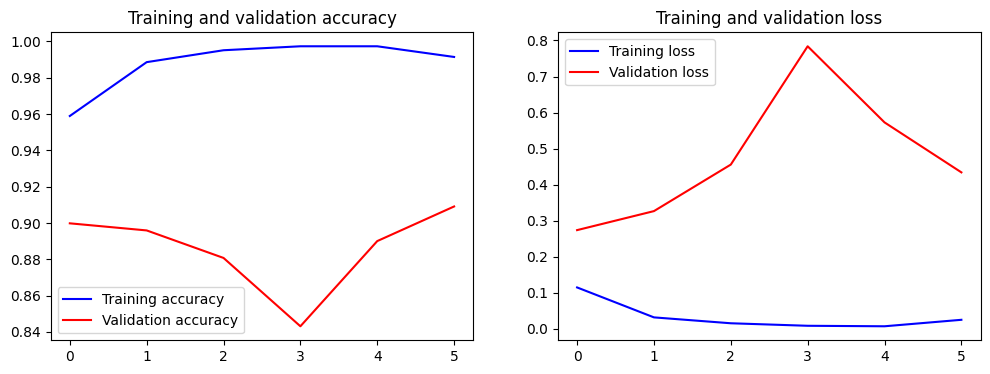

34/34 [==============================] - 6s 158ms/step - loss: 0.1920 - accuracy: 0.9311
Test Accuracy: 0.9311320781707764
34/34 [==============================] - 5s 150ms/step


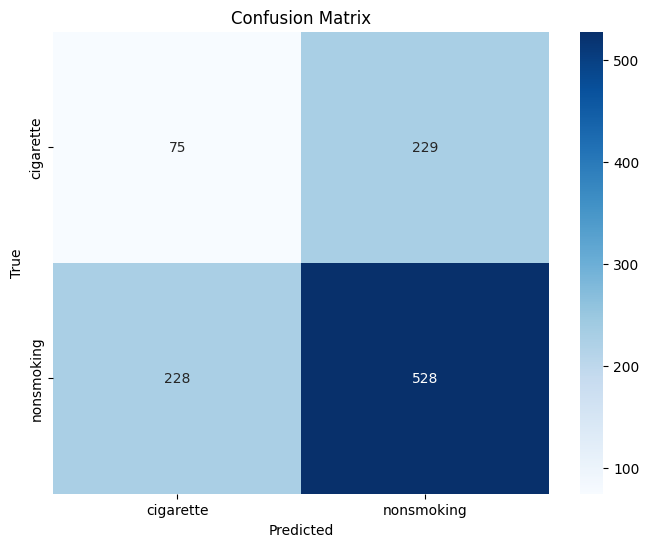

              precision    recall  f1-score   support

   cigarette       0.25      0.25      0.25       304
  nonsmoking       0.70      0.70      0.70       756

    accuracy                           0.57      1060
   macro avg       0.47      0.47      0.47      1060
weighted avg       0.57      0.57      0.57      1060



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = np.round(Y_pred).astype(int).flatten()

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

{'cigarette': 0, 'nonsmoking': 1}
{0: 'cigarette', 1: 'nonsmoking'}
64/64 [==============================] - 10s 156ms/step


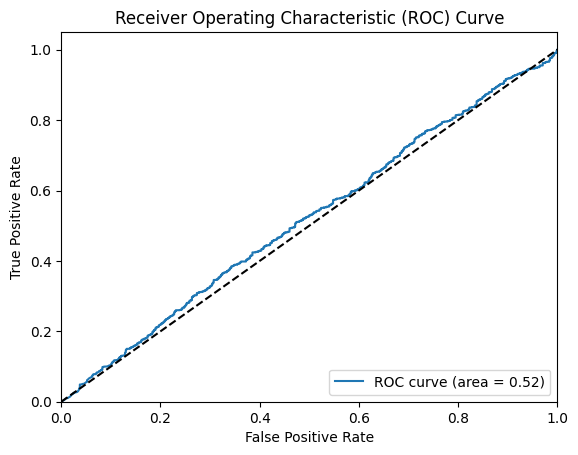

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
y_pred_prob = model.predict(valid_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = valid_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
